In [5]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.9.1+cu128
True


In [6]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.2166, 0.8154, 0.6256],
        [0.1942, 0.5253, 0.0170],
        [0.8288, 0.2207, 0.5181],
        [0.5349, 0.2193, 0.5513],
        [0.2298, 0.4211, 0.6396]])


In [7]:
import torch
torch.cuda.is_available()

True

In [8]:
import torch

# 1. 创建张量（PyTorch的基本数据结构，类似Numpy数组）
# 创建一个随机初始化的2x3张量
x = torch.rand(2, 3)
print("随机张量 x:\n", x)

# 创建一个全为0的张量，指定数据类型为float32
y = torch.zeros(2, 3, dtype=torch.float32)
print("\n全0张量 y:\n", y)

# 2. 张量基本运算
z = x + y  # 加法
print("\nx + y 的结果:\n", z)

# 3. 查看张量属性
print("\n张量 z 的形状:", z.shape)  # 形状
print("张量 z 的数据类型:", z.dtype)  # 数据类型
print("张量 z 所在设备:", z.device)  # 所在设备（CPU/GPU）

# 4. 利用GPU加速（如果之前验证过torch.cuda.is_available()为True）
if torch.cuda.is_available():
    # 将张量移动到GPU
    x_gpu = x.to("cuda")
    y_gpu = y.to("cuda")
    z_gpu = x_gpu + y_gpu
    print("\nGPU加速可用")
    print("\nGPU上的计算结果:\n", z_gpu)
    print("GPU张量所在设备:", z_gpu.device)
else:
    print("\n当前环境不支持GPU加速，使用CPU计算")

随机张量 x:
 tensor([[0.2508, 0.7513, 0.0192],
        [0.8606, 0.7445, 0.3574]])

全0张量 y:
 tensor([[0., 0., 0.],
        [0., 0., 0.]])

x + y 的结果:
 tensor([[0.2508, 0.7513, 0.0192],
        [0.8606, 0.7445, 0.3574]])

张量 z 的形状: torch.Size([2, 3])
张量 z 的数据类型: torch.float32
张量 z 所在设备: cpu

GPU加速可用

GPU上的计算结果:
 tensor([[0.2508, 0.7513, 0.0192],
        [0.8606, 0.7445, 0.3574]], device='cuda:0')
GPU张量所在设备: cuda:0


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 设置设备（优先使用GPU，没有则用CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: cuda


In [10]:
# 数据预处理：转换为张量并标准化
transform = transforms.Compose([
    transforms.ToTensor(),  # 转换为Tensor（0-1范围）
    transforms.Normalize((0.1307,), (0.3081,))  # 标准化（MNIST的均值和标准差）
])

# 加载训练集和测试集
train_dataset = datasets.MNIST(
    root="./data",  # 数据保存路径
    train=True,     # 训练集
    download=True,  # 若本地没有则自动下载
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,    # 测试集
    download=True,
    transform=transform
)

# 数据加载器（按批次加载数据，支持打乱和多线程）
batch_size = 64  # 每批处理64张图片
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100.0%
100.0%
100.0%
100.0%


In [11]:
class SimpleMNISTModel(nn.Module):
    def __init__(self):
        super(SimpleMNISTModel, self).__init__()
        self.flatten = nn.Flatten()  # 将28×28的图像展平为784维向量
        self.fc1 = nn.Linear(784, 128)  # 输入层→隐藏层
        self.relu = nn.ReLU()           # 激活函数
        self.fc2 = nn.Linear(128, 10)   # 隐藏层→输出层

    def forward(self, x):
        x = self.flatten(x)    # 展平：(batch_size, 1, 28, 28) → (batch_size, 784)
        x = self.fc1(x)        # 线性变换：784→128
        x = self.relu(x)       # 激活：引入非线性
        x = self.fc2(x)        # 线性变换：128→10（输出10个类别的得分）
        return x

# 初始化模型并移动到设备
model = SimpleMNISTModel().to(device)
print(model)  # 打印模型结构

SimpleMNISTModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [12]:
criterion = nn.CrossEntropyLoss()  # 损失函数
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # 优化器（学习率0.01）

In [13]:
def train(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()  # 切换到训练模式
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            # 数据移动到设备
            data, target = data.to(device), target.to(device)
            
            # 1. 前向传播：计算预测值
            outputs = model(data)
            # 2. 计算损失
            loss = criterion(outputs, target)
            
            # 3. 反向传播+参数更新
            optimizer.zero_grad()  # 清空上一轮梯度
            loss.backward()        # 反向传播计算梯度
            optimizer.step()       # 更新参数
            
            # 打印训练进度
            running_loss += loss.item()
            if batch_idx % 300 == 299:  # 每300个批次打印一次
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/300:.4f}")
                running_loss = 0.0

# 训练5个 epoch
train(model, train_loader, criterion, optimizer, device, epochs=5)

Epoch [1/5], Batch [300/938], Loss: 0.4646
Epoch [1/5], Batch [600/938], Loss: 0.2239
Epoch [1/5], Batch [900/938], Loss: 0.1760
Epoch [2/5], Batch [300/938], Loss: 0.1299
Epoch [2/5], Batch [600/938], Loss: 0.1178
Epoch [2/5], Batch [900/938], Loss: 0.1102
Epoch [3/5], Batch [300/938], Loss: 0.0838
Epoch [3/5], Batch [600/938], Loss: 0.0813
Epoch [3/5], Batch [900/938], Loss: 0.0823
Epoch [4/5], Batch [300/938], Loss: 0.0589
Epoch [4/5], Batch [600/938], Loss: 0.0625
Epoch [4/5], Batch [900/938], Loss: 0.0611
Epoch [5/5], Batch [300/938], Loss: 0.0476
Epoch [5/5], Batch [600/938], Loss: 0.0499
Epoch [5/5], Batch [900/938], Loss: 0.0492


In [14]:
def test(model, test_loader, device):
    model.eval()  # 切换到评估模式（关闭dropout等）
    correct = 0
    total = 0
    with torch.no_grad():  # 关闭梯度计算，节省内存
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)  # 取预测概率最大的类别
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    print(f"测试集准确率: {100 * correct / total:.2f}%")

# 测试模型
test(model, test_loader, device)

测试集准确率: 97.90%


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 数据加载与预处理（同之前）
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 模型定义（同之前）
class SimpleMNISTModel(nn.Module):
    def __init__(self):
        super(SimpleMNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = SimpleMNISTModel().to(device)

# 损失函数和优化器（同之前）
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# 改进的训练函数：每个epoch结束后计算准确率
def train(model, train_loader, test_loader, criterion, optimizer, device, epochs=5):
    for epoch in range(epochs):
        # 训练阶段
        model.train()  # 训练模式
        train_running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            
            # 前向传播
            outputs = model(data)
            loss = criterion(outputs, target)
            
            # 反向传播+更新
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 累计训练损失
            train_running_loss += loss.item()
            
            # 计算训练准确率（当前批次）
            _, predicted = torch.max(outputs.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        
        # 计算当前epoch的训练损失和准确率
        train_avg_loss = train_running_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        
        # 测试阶段（每个epoch后在测试集上验证）
        model.eval()  # 评估模式
        test_correct = 0
        test_total = 0
        with torch.no_grad():  # 关闭梯度计算
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                test_total += target.size(0)
                test_correct += (predicted == target).sum().item()
        test_acc = 100 * test_correct / test_total
        
        # 打印当前epoch的结果
        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"  训练集 - 损失: {train_avg_loss:.4f}, 准确率: {train_acc:.2f}%")
        print(f"  测试集 - 准确率: {test_acc:.2f}%")
        print("----------------------------------------")

# 训练5个epoch（每个epoch后输出准确率）
train(model, train_loader, test_loader, criterion, optimizer, device, epochs=5)

使用设备: cuda
Epoch [1/5]
  训练集 - 损失: 0.2825, 准确率: 91.74%
  测试集 - 准确率: 95.81%
----------------------------------------
Epoch [2/5]
  训练集 - 损失: 0.1185, 准确率: 96.53%
  测试集 - 准确率: 96.81%
----------------------------------------
Epoch [3/5]
  训练集 - 损失: 0.0819, 准确率: 97.51%
  测试集 - 准确率: 97.29%
----------------------------------------
Epoch [4/5]
  训练集 - 损失: 0.0619, 准确率: 98.19%
  测试集 - 准确率: 97.52%
----------------------------------------
Epoch [5/5]
  训练集 - 损失: 0.0483, 准确率: 98.56%
  测试集 - 准确率: 97.63%
----------------------------------------


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 数据加载与预处理（同之前）
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 模型定义（同之前）
class SimpleMNISTModel(nn.Module):
    def __init__(self):
        super(SimpleMNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = SimpleMNISTModel().to(device)

# 损失函数和优化器（同之前）
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# 改进的训练函数：每个epoch结束后计算准确率
def train(model, train_loader, test_loader, criterion, optimizer, device, epochs=5):
    for epoch in range(epochs):
        # 训练阶段
        model.train()  # 训练模式
        train_running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            
            # 前向传播
            outputs = model(data)
            loss = criterion(outputs, target)
            
            # 反向传播+更新
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 累计训练损失
            train_running_loss += loss.item()
            
            # 计算训练准确率（当前批次）
            _, predicted = torch.max(outputs.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        
        # 计算当前epoch的训练损失和准确率
        train_avg_loss = train_running_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        
        # 测试阶段（每个epoch后在测试集上验证）
        model.eval()  # 评估模式
        test_correct = 0
        test_total = 0
        with torch.no_grad():  # 关闭梯度计算
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                test_total += target.size(0)
                test_correct += (predicted == target).sum().item()
        test_acc = 100 * test_correct / test_total
        
        # 打印当前epoch的结果
        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"  训练集 - 损失: {train_avg_loss:.4f}, 准确率: {train_acc:.2f}%")
        print(f"  测试集 - 准确率: {test_acc:.2f}%")
        print("----------------------------------------")

# 训练5个epoch（每个epoch后输出准确率）
train(model, train_loader, test_loader, criterion, optimizer, device, epochs=5)

使用设备: cuda
Epoch [1/5]
  训练集 - 损失: 0.2715, 准确率: 92.05%
  测试集 - 准确率: 96.18%
----------------------------------------
Epoch [2/5]
  训练集 - 损失: 0.1146, 准确率: 96.61%
  测试集 - 准确率: 97.12%
----------------------------------------
Epoch [3/5]
  训练集 - 损失: 0.0801, 准确率: 97.64%
  测试集 - 准确率: 97.40%
----------------------------------------
Epoch [4/5]
  训练集 - 损失: 0.0609, 准确率: 98.19%
  测试集 - 准确率: 97.63%
----------------------------------------
Epoch [5/5]
  训练集 - 损失: 0.0493, 准确率: 98.46%
  测试集 - 准确率: 97.90%
----------------------------------------


Using device: cuda

Epoch 1/10
----------


C:\Users\DID\AppData\Local\Temp\ipykernel_28836\469343271.py:125: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\DID\AppData\Local\Temp\ipykernel_28836\469343271.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[1,   300] loss: 0.578
[1,   600] loss: 0.232
[1,   900] loss: 0.167
Test set: Average loss: 0.1298, Accuracy: 9614/10000 (96.14%)

Epoch 2/10
----------
[2,   300] loss: 0.125
[2,   600] loss: 0.104
[2,   900] loss: 0.108
Test set: Average loss: 0.1049, Accuracy: 9668/10000 (96.68%)

Epoch 3/10
----------
[3,   300] loss: 0.072
[3,   600] loss: 0.080
[3,   900] loss: 0.077
Test set: Average loss: 0.0878, Accuracy: 9718/10000 (97.18%)

Epoch 4/10
----------
[4,   300] loss: 0.054
[4,   600] loss: 0.057
[4,   900] loss: 0.060
Test set: Average loss: 0.0849, Accuracy: 9731/10000 (97.31%)

Epoch 5/10
----------
[5,   300] loss: 0.043
[5,   600] loss: 0.045
[5,   900] loss: 0.044
Test set: Average loss: 0.0706, Accuracy: 9786/10000 (97.86%)

Epoch 6/10
----------
[6,   300] loss: 0.032
[6,   600] loss: 0.034
[6,   900] loss: 0.039
Test set: Average loss: 0.0717, Accuracy: 9778/10000 (97.78%)

Epoch 7/10
----------
[7,   300] loss: 0.025
[7,   600] loss: 0.027
[7,   900] loss: 0.029
Test se

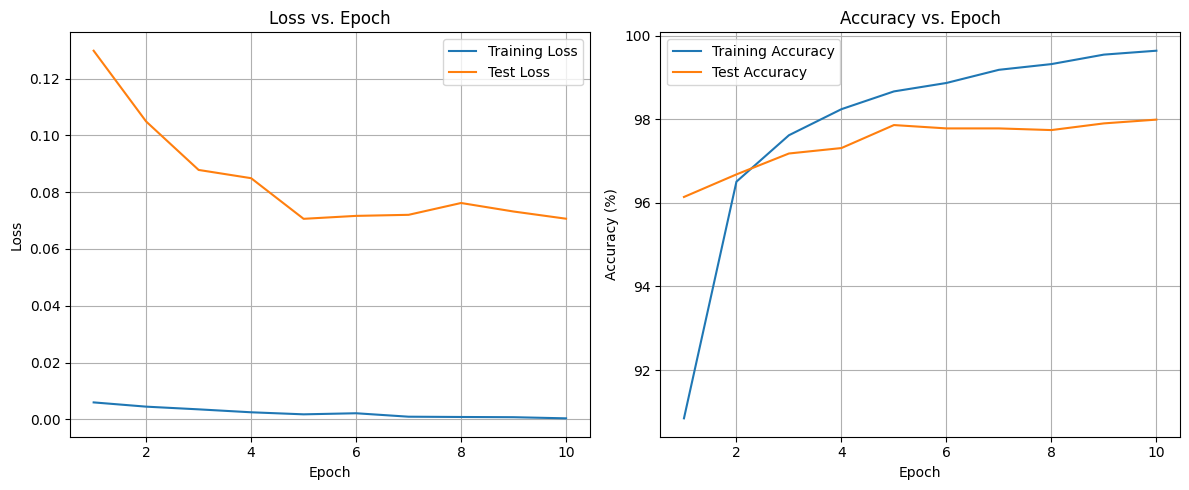

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# --- 1. 超参数设置 ---
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.01
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 2. 数据加载与预处理 ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 3. 模型定义 ---
class SimpleMNISTModel(nn.Module):
    def __init__(self):
        super(SimpleMNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.leaky_relu2(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleMNISTModel().to(DEVICE)

# --- 4. 损失函数与优化器 ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

# --- 5. 训练与测试函数 (加入记录功能) ---
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)

        optimizer.zero_grad()

        # 混合精度训练
        with torch.cuda.amp.autocast():
            outputs = model(data)
            loss = criterion(outputs, target)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        # 每300个batch打印一次信息
        if batch_idx % 300 == 299:
            print(f'[{epoch + 1}, {batch_idx + 1:5d}] loss: {running_loss / 300:.3f}')
            running_loss = 0.0

    # 计算并返回本轮的平均损失和准确率
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    return train_loss, train_acc

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    # 计算并返回测试集的平均损失和准确率
    test_loss /= len(test_loader)
    test_acc = 100 * correct / total
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({test_acc:.2f}%)')
    return test_loss, test_acc

# --- 6. 主训练循环 ---
def main():
    # 用于记录每一轮的指标
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    # 初始化混合精度训练的scaler
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)

        # 训练一个epoch并获取指标
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, epoch)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # 在测试集上评估并获取指标
        test_loss, test_acc = test(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    print('Training complete!')

    # --- 7. 结果可视化 ---
    plot_results(train_losses, train_accs, test_losses, test_accs, EPOCHS)

def plot_results(train_losses, train_accs, test_losses, test_accs, epochs):
    plt.figure(figsize=(12, 5))

    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accs, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), test_accs, label='Test Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

Using device: cuda

Epoch 1/20
----------


C:\Users\DID\AppData\Local\Temp\ipykernel_28836\1561535836.py:122: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\DID\AppData\Local\Temp\ipykernel_28836\1561535836.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[1,   300] loss: 0.572
[1,   600] loss: 0.226
[1,   900] loss: 0.176
Test set: Average loss: 0.1533, Accuracy: 9526/10000 (95.26%)

Epoch 2/20
----------
[2,   300] loss: 0.130
[2,   600] loss: 0.112
[2,   900] loss: 0.105
Test set: Average loss: 0.0976, Accuracy: 9706/10000 (97.06%)

Epoch 3/20
----------
[3,   300] loss: 0.077
[3,   600] loss: 0.075
[3,   900] loss: 0.076
Test set: Average loss: 0.0896, Accuracy: 9736/10000 (97.36%)

Epoch 4/20
----------
[4,   300] loss: 0.058
[4,   600] loss: 0.058
[4,   900] loss: 0.059
Test set: Average loss: 0.0838, Accuracy: 9731/10000 (97.31%)

Epoch 5/20
----------
[5,   300] loss: 0.039
[5,   600] loss: 0.045
[5,   900] loss: 0.046
Test set: Average loss: 0.0775, Accuracy: 9761/10000 (97.61%)

Epoch 6/20
----------
[6,   300] loss: 0.033
[6,   600] loss: 0.038
[6,   900] loss: 0.032
Test set: Average loss: 0.0790, Accuracy: 9762/10000 (97.62%)

Epoch 7/20
----------
[7,   300] loss: 0.025
[7,   600] loss: 0.028
[7,   900] loss: 0.029
Test se

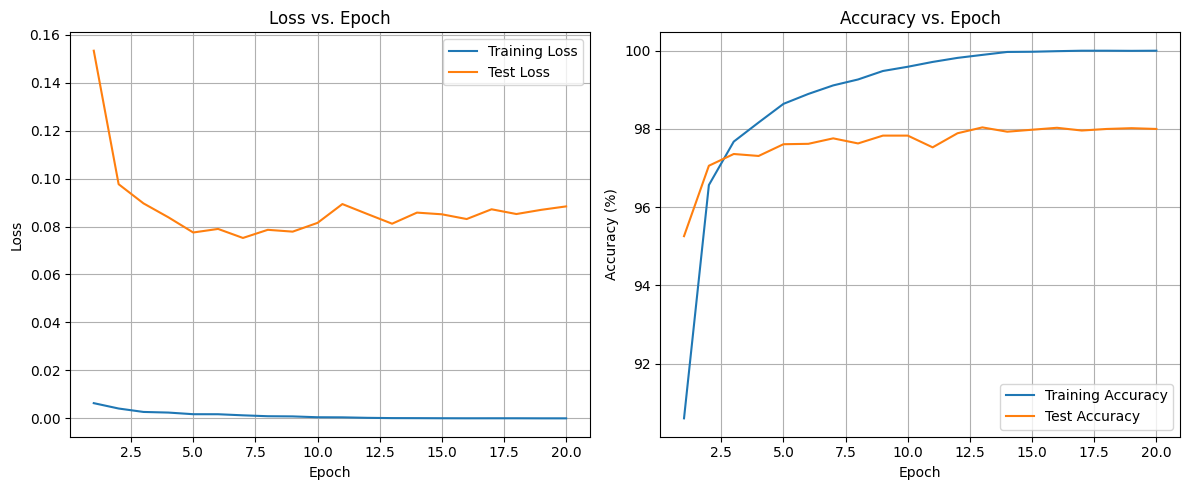

Results saved to 'training_results.npy'


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# --- 1. 超参数设置 ---
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 0.01
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 2. 数据加载与预处理 ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 3. 模型定义 ---
class SimpleMNISTModel(nn.Module):
    def __init__(self):
        super(SimpleMNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.leaky_relu2(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleMNISTModel().to(DEVICE)

# --- 4. 损失函数与优化器 ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

# --- 5. 训练与测试函数 ---
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(data)
            loss = criterion(outputs, target)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        if batch_idx % 300 == 299:
            print(f'[{epoch + 1}, {batch_idx + 1:5d}] loss: {running_loss / 300:.3f}')
            running_loss = 0.0

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    return train_loss, train_acc

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100 * correct / total
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({test_acc:.2f}%)')
    return test_loss, test_acc

# --- 6. 主训练循环 (加入结果保存) ---
def main():
    # 初始化列表，用于保存每一轮的指标
    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)

        # 训练并获取指标
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, epoch)
        
        # 测试并获取指标
        test_loss, test_acc = test(model, test_loader, criterion)
        
        # 将指标保存到列表中
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    print('\nTraining complete!')

    # --- 7. 结果可视化 (使用保存的数据) ---
    plot_results(results, EPOCHS)
    
    # --- 8. (可选) 将结果保存为Numpy数组或CSV文件 ---
    # 保存为Numpy数组
    np.save('./training_results.npy', results)
    print("Results saved to 'training_results.npy'")
    
    # # 或者保存为CSV文件 (需要导入pandas)
    # import pandas as pd
    # df = pd.DataFrame(results)
    # df.to_csv('./training_results.csv', index_label='Epoch')
    # print("Results saved to 'training_results.csv'")

def plot_results(results, epochs):
    # 从保存的结果中提取数据
    train_losses = results['train_loss']
    train_accs = results['train_acc']
    test_losses = results['test_loss']
    test_accs = results['test_acc']
    
    # 绘图
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accs, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), test_accs, label='Test Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()